# Module 1.12: Reading the Patterns — Measuring & Deciding

> **Goal:** Quantify what you saw and translate patterns into modeling decisions.

In 1.12, you saw trends, seasonality, intermittency, distribution shapes, and anomalies. But "I see a trend" isn't actionable. You need to know: *How strong? How consistent? What do I do about it?*

This module bridges observation → measurement → decision.

| 1.12 (What I Saw) | 1.13 (What I'll Measure) | Decision |
|-------------------|--------------------------|----------|
| "Looks like there's a trend" | Trend strength = 0.7 | Include trend component |
| "December peaks" | Seasonal strength = 0.5 | Period=52, holiday features |
| "Lots of zeros" | 40% lumpy, 15% smooth | Segment before modeling |
| "Right-skewed distribution" | Skewness = 2.3 | Log transform |
| "Variance grows with level" | Heteroscedastic = True | Multiplicative model |
| "Unexplained spikes" | 30% have outliers | Robust methods |

---

## 1. Setup

In [1]:
# =============================================================================
# SETUP
# =============================================================================

# --- Imports ---
import sys
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Path Configuration (before local imports) ---
MODULE_DIR = Path().resolve()
PROJECT_ROOT = MODULE_DIR.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

import tsforge as tsf
from src import (
    CacheManager,
    ArtifactManager,
    get_notebook_name,
    profile_series,
    profile_dataframe,
    summarize_profiles,
    calc_stl_strength,
    interpret_strength,
    acf_summary
)

# --- Settings ---
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

# --- Paths ---
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

# --- Managers ---
NB_NAME = get_notebook_name()  # e.g., '1_06_first_contact'
cache = CacheManager(PROJECT_ROOT / ".cache" / NB_NAME)
artifacts = ArtifactManager(PROJECT_ROOT / "artifacts")

print(f"✓ Setup complete | Root: {PROJECT_ROOT.name} | Module: {NB_NAME[:4]}")

✓ Setup complete | Root: real-world-forecasting-foundations | Module: 1_12


In [2]:
# --- Load Data from Module 1.08 ---
df = artifacts.load('1.08')

✓ Loaded '1.08' from 01_foundations/
   Shape: 6,848,887 × 20


---

## 2. Trend & Seasonality: Decomposition Strength

STL breaks a series into **trend + seasonal + residual**. We measure how much each component explains.

### 2.1 Visualizing Decomposition

In [3]:
tsf.plot_decomposition(df, id_col='unique_id',
                       date_col='ds',
                       value_col='y',
                       mode='dropdown',
                       period=52)

### 2.2 Quantifying Strength: One Series

**Trend strength** and **seasonal strength** range from 0 (none) to 1 (dominant).

Formula (Wang-Hyndman-Talagala):
```
Trend strength    = max(0, 1 - Var(residual) / Var(trend + residual))
Seasonal strength = max(0, 1 - Var(residual) / Var(seasonal + residual))
```

In [4]:
# Single series example
series_id = df['unique_id'].iloc[0]
series = df[df['unique_id'] == series_id]['y']

trend_str, seasonal_str = calc_stl_strength(series, period=52)

print(f"Series: {series_id}")
print(f"Trend strength:    {trend_str:.2f} ({interpret_strength(trend_str)})")
print(f"Seasonal strength: {seasonal_str:.2f} ({interpret_strength(seasonal_str)})")

Series: FOODS_1_001_CA_1
Trend strength:    0.06 (Weak)
Seasonal strength: 0.12 (Weak)


**Interpretation:**

| Value | Meaning |
|-------|---------|  
| 0.0 - 0.3 | Weak — probably noise, don't model explicitly |
| 0.3 - 0.6 | Moderate — include but don't over-weight |
| 0.6 - 1.0 | Strong — definitely model this component |

---

## 3. Full Portfolio Profile

One series tells you about that series. To make portfolio-level decisions, we profile many series across all dimensions:

- **Trend & Seasonal** — STL decomposition strength
- **Autocorrelation** — Lag-1 and lag-52 ACF
- **Intermittency** — ADI, CV², Syntetos-Boylan classification
- **Distribution** — Skewness, kurtosis, log transform benefit
- **Volatility** — Does variance scale with level?
- **Outliers** — IQR-based detection

In [5]:
# Profile 500 series (full portfolio would take ~50 min)
profiles = profile_dataframe(
    df,
    id_col='unique_id',
    value_col='y',
    period=52,
    sample_n=500,
    random_state=42
)

Profiling series: 100%|██████████| 500/500 [00:17<00:00, 28.36it/s]


In [6]:
profiles.head()

,trend_strength,seasonal_strength,acf_lag1,acf_lag52,zero_pct,cv,cv2,adi,demand_class,skewness,kurtosis,log_beneficial,level_var_corr,is_heteroscedastic,n_outliers,outlier_pct,has_outliers,unique_id
0,0.270413,0.000000,0.649237,-0.245905,0.490347,1.256252,1.578170,1.961832,Lumpy,1.149781,2.081817,True,0.821299,True,3,0.022727,True,FOODS_2_206_TX_2
1,0.038147,0.289138,0.217078,-0.017488,0.210762,0.821899,0.675519,1.262857,Erratic,0.840946,-0.039501,True,0.798699,True,0,0.000000,False,HOUSEHOLD_1_451_TX_2
2,0.000000,0.436099,0.135866,-0.057809,0.152866,1.067169,1.138850,1.174242,Erratic,2.095009,5.449812,True,0.860921,True,7,0.052632,True,HOBBIES_1_387_TX_1
3,0.007539,0.484157,0.465265,0.304656,0.233216,1.405979,1.976777,1.300926,Erratic,2.339814,6.492742,True,0.957198,True,18,0.082949,True,HOBBIES_2_059_WI_1
4,0.150573,0.389133,0.310530,0.069758,0.010601,0.429507,0.184476,1.010753,Smooth,0.444627,0.370135,True,0.483611,False,2,0.007143,False,FOODS_3_273_CA_1


---

## 4. Portfolio Summary

Aggregate findings across all profiled series.

In [7]:
summary = summarize_profiles(profiles)
summary

,Metric,Value,Implication
Trend,Strong trend (>0.6),6.6%,Include trend component
Seasonal,Strong seasonal (>0.6),10.8%,"Period=52, holiday features"
ACF Lag-1,Significant lag-1 (>0.3),62.2%,AR(1) / lag features
ACF Lag-52,Significant lag-52 (>0.2),7.8%,Same-week-last-year feature
Intermittency,Lumpy demand,43.8%,Croston/TSB for these series
Distribution,Right-skewed (>1),53.2%,Log transform
Volatility,Variance scales with level,22.1%,Multiplicative seasonality
Outliers,Has outliers (>2%),47.6%,Robust methods or pre-clean


---

## 5. Visual Diagnostics

### 5.1 Trend & Seasonal Strength Distribution

In [8]:
tsf.plot_strength(profiles)

### 5.2 Intermittency Classification

In [9]:
demand_classes = profiles['demand_class'].value_counts(normalize=True).round(3)
demand_classes

demand_class
Lumpy      0.438
Smooth     0.302
Erratic    0.260
Name: proportion, dtype: float64

<Axes: title={'center': 'Demand Classification Distribution'}, xlabel='demand_class', ylabel='Proportion'>

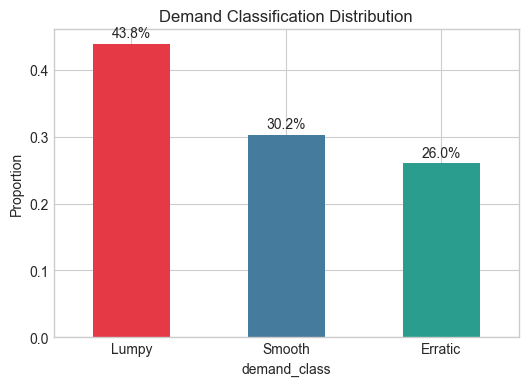

In [10]:
tsf.plot_demand_bars(profiles['demand_class'])

### 5.3 Distribution Skewness

<Axes: title={'center': 'Distribution Skewness Across Portfolio'}, xlabel='Skewness', ylabel='Count'>

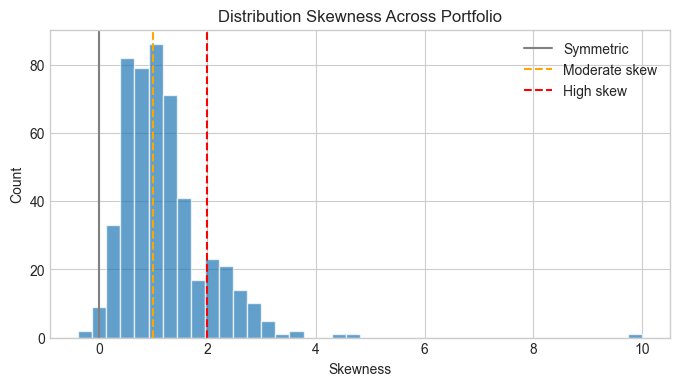

In [11]:
tsf.plot_skewness(profiles)

### 5.4 ACF Summary

In [12]:
tsf.plot_autocorrelation(df, id_col='unique_id', date_col='ds', value_col='y', ids=1, lags=60, layout='stacked')

In [13]:
acf_summary(profiles)

,Lag,Threshold,Significant,Implication
0,Lag-1,> 0.3,62.2%,AR(1) / lag features
1,Lag-52,> 0.2,7.8%,Same-week-last-year


---

## 6. Pattern → Decision Matrix

### 6.1 Decision Rules

| If you measured... | Then... |
|--------------------|---------|
| Trend strength > 0.6 | Include trend component; don't over-difference |
| Seasonal strength > 0.6 | Use period=52; add holiday features |
| ACF lag-1 > 0.3 | AR(1) or lag-1 feature essential |
| ACF lag-52 > 0.2 | Same-week-last-year feature helps |
| Demand class = Lumpy | Use Croston/TSB, not standard methods |
| Skewness > 1 | Log transform the target |
| Heteroscedastic = True | Multiplicative model or log transform |
| Has outliers = True | Robust loss function or pre-clean |

### 6.2 Feature Engineering Implications

| Pattern | Features to Create |
|---------|--------------------|
| Strong lag-1 ACF | `lag_1`, `lag_2`, `lag_3`, `rolling_mean_4w` |
| Strong lag-52 ACF | `lag_52`, `lag_53`, `rolling_mean_52w` |
| Strong seasonality | `week_of_year`, `month`, `is_december` |
| December peaks | `weeks_to_christmas`, `is_holiday_week` |
| Heteroscedastic | `lag_1 / rolling_mean` (ratio features) |
| Category effects | `cat_id` encoding, category aggregates |

---

## 7. Module Artifact: Modeling Strategy

### 7.1 What We Measured

In [14]:
summary

,Metric,Value,Implication
Trend,Strong trend (>0.6),6.6%,Include trend component
Seasonal,Strong seasonal (>0.6),10.8%,"Period=52, holiday features"
ACF Lag-1,Significant lag-1 (>0.3),62.2%,AR(1) / lag features
ACF Lag-52,Significant lag-52 (>0.2),7.8%,Same-week-last-year feature
Intermittency,Lumpy demand,43.8%,Croston/TSB for these series
Distribution,Right-skewed (>1),53.2%,Log transform
Volatility,Variance scales with level,22.1%,Multiplicative seasonality
Outliers,Has outliers (>2%),47.6%,Robust methods or pre-clean


### 7.2 Modeling Decisions

| Decision | Source | Rationale |
|----------|--------|-----------|
| Segment by intermittency first | Intermittency analysis | Lumpy series need Croston/TSB |
| Use multiplicative seasonality | Volatility analysis | Variance scales with level |
| Period = 52 | Seasonal strength | Confirmed by decomposition |
| Include AR(1) | ACF analysis | Lag-1 significant in most series |
| Add same-week-last-year | ACF analysis | Lag-52 significant |
| Log transform for smooth series | Distribution analysis | Right-skewed, stabilizes variance |
| Robust methods for some series | Outlier analysis | Significant outliers present |

### 7.3 Open Questions

- After fitting baselines, do residuals still show patterns? → missing features
- Do outliers correspond to known events (holidays, promotions)? → feature engineering
- Does log transform help more than multiplicative models? → experiment

---

## Key Principle

> **Observation → Measurement → Decision**

| 1.11 Observation | 1.12 Measurement | Decision |
|------------------|------------------|----------|
| "I see a trend" | Trend strength = 0.7 | Include trend component |
| "December peaks" | Seasonal strength = 0.5 | Period=52, holidays |
| "Lots of zeros" | 40% Lumpy | Segment, use Croston |
| "Right-skewed" | Skewness = 2.3 | Log transform |
| "Variance grows" | Heteroscedastic = 55% | Multiplicative model |
| "Spikes" | 30% have outliers | Robust methods |

---

## Next Steps

| Module | Focus |
|--------|-------|
| **2.01** | Baseline Models — Naive, Seasonal Naive |
| **2.02** | Statistical Models — Apply ETS, ARIMA based on what we learned |